In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve


In [2]:
df = pd.read_csv(r"C:\Users\DHONI HANIF\OneDrive\Documents\AI_Collection_and_Loss_Reverse_Forecast\modelling\nasabah\clustering\data\data_for_classification.csv")
df.sample(5)

,Unnamed: 0,net_income,loan_amount,amount_of_late,late_payment_amount,credit_score,arrears_amounts,loss_reverse,credit_risk
3372,3372,26500000.0,1.380000e+08,2.0,2.0,644.0,0.0,0.000000e+00,Tidak tertagih dengan resiko rendah
2656,2656,19000000.0,6.100000e+07,42.0,2.0,573.0,1.0,1.525000e+07,Tidak tertagih dengan resiko tinggi
3495,3495,9700000.0,5.933333e+07,47.0,2.0,260.0,2.0,2.966667e+07,Tertagih dengan resiko tinggi
4148,4148,10500000.0,6.216667e+07,39.0,4.0,311.0,1.0,1.554167e+07,Tidak tertagih dengan resiko tinggi
798,798,11500000.0,6.566667e+07,92.0,4.0,272.0,2.0,3.283333e+07,Tertagih dengan resiko tinggi


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           5000 non-null   int64  
 1   net_income           5000 non-null   float64
 2   loan_amount          5000 non-null   float64
 3   amount_of_late       5000 non-null   float64
 4   late_payment_amount  5000 non-null   float64
 5   credit_score         5000 non-null   float64
 6   arrears_amounts      5000 non-null   float64
 7   loss_reverse         5000 non-null   float64
 8   credit_risk          5000 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 351.7+ KB


In [4]:
for i in df.columns:
    if df[i].dtype == "object":
        df[i] = df[i].astype("category")

df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [5]:
columns = {}
for i in df.columns:
    if df[i].dtype == "category" or df[i].dtype == "object":
        columns[i] = LabelEncoder().fit(df[i])
        df[i] = columns[i].transform(df[i])
             
scaler = RobustScaler().fit(df[[i for i in df.columns if i not in columns]])
df2 = pd.DataFrame(scaler.transform(df[[i for i in df.columns if i not in columns]]), columns=df[[i for i in df.columns if i not in columns]].columns)
for i in columns:
    df2[i] = df[i]
df2.head(5)

,net_income,loan_amount,amount_of_late,late_payment_amount,credit_score,arrears_amounts,loss_reverse,credit_risk
0,0.000000,0.190476,-0.800000,-0.6,1.589041,-1.0,-0.928218,3
1,0.266667,0.984127,-0.413333,-0.2,0.365297,0.0,0.123762,3
2,0.266667,-0.111111,-0.826667,-0.8,0.835616,-1.0,-0.928218,3
3,0.000000,0.063492,0.026667,0.2,0.849315,0.0,-0.019802,3
4,-0.906667,-0.412698,-0.640000,-0.4,0.223744,-1.0,-0.928218,3


In [6]:
X = df2.drop("credit_risk", axis=1)
y = df2["credit_risk"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 7), (1000, 7), (4000,), (1000,))

In [7]:
model = BaggingClassifier()
model.fit(X_train, y_train)

BaggingClassifier()

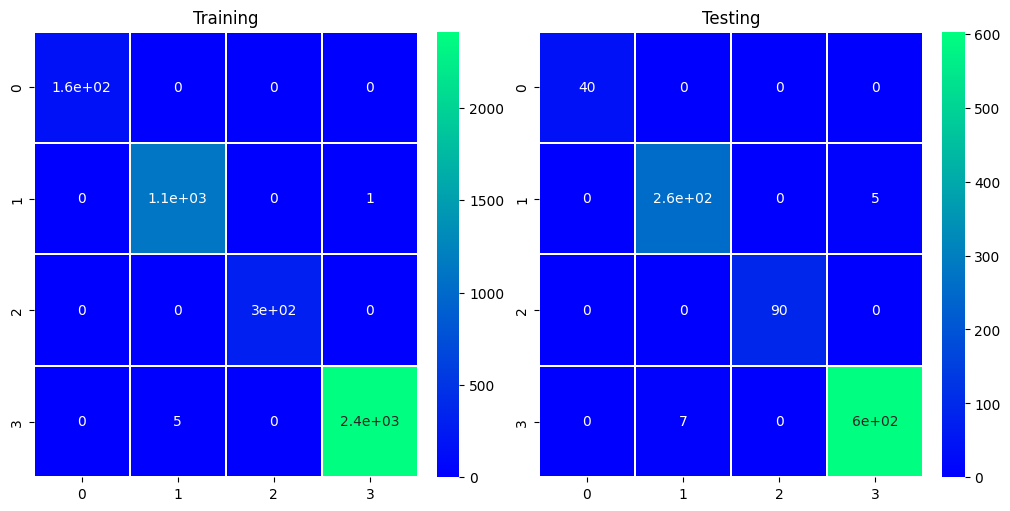

In [8]:
y_pred = model.predict(X_test)
fig, ax = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")
sns.heatmap(confusion_matrix(y_train, model.predict(X_train)), annot=True, linecolor="white", linewidths=0.2, cmap="winter", ax=ax[0])
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, linecolor="white", linewidths=0.2, cmap="winter", ax=ax[1])

ax[0].set_title("Training")
ax[1].set_title("Testing")
plt.show()

In [9]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.97      0.98      0.98       260
           2       1.00      1.00      1.00        90
           3       0.99      0.99      0.99       610

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



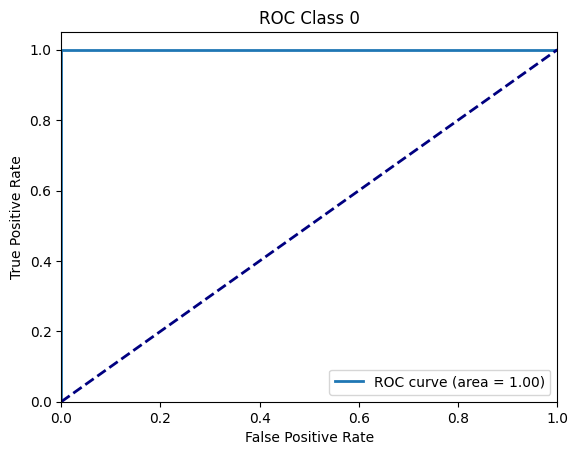

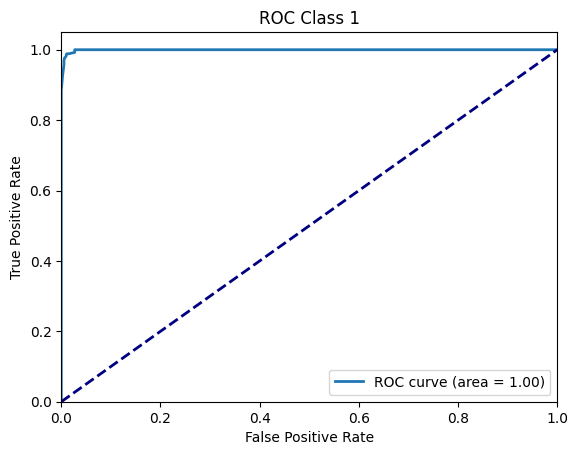

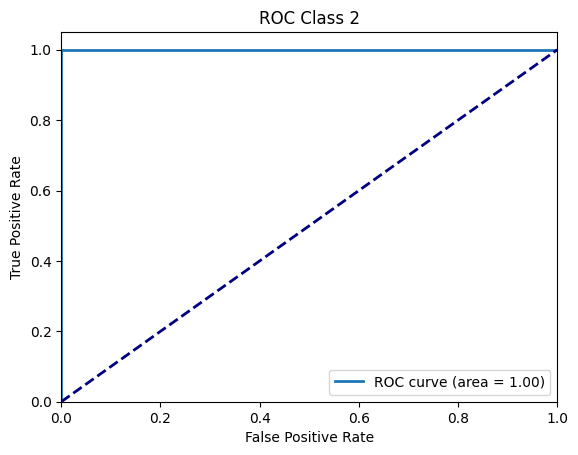

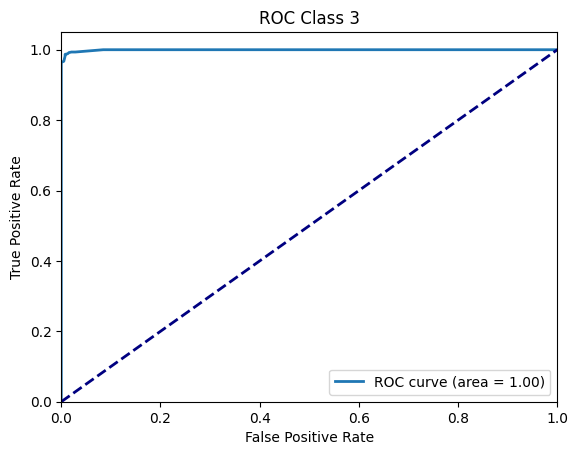

Macro-Averaged ROC AUC: 1.00


In [10]:
# Convert y_test to binary format for each class
n_classes = 4  # Number of classes
y_binary = np.zeros((len(y_test), n_classes))
y_prob = model.predict_proba(X_test)
for i in range(n_classes):
    y_binary[:, i] = (y_test == i).astype(int)

# Calculate ROC AUC for each class
roc_auc_list = []
for i in range(n_classes):
    roc_auc = roc_auc_score(y_binary[:, i], y_prob[:, i])
    roc_auc_list.append(roc_auc)

    # Calculate ROC curve for each class
    fpr, tpr, _ = roc_curve(y_binary[:, i], y_prob[:, i])

    # Display ROC curve
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Class {i}')
    plt.legend(loc='lower right')
    plt.show()

# Display Macro-Averaged ROC AUC
print(f'Macro-Averaged ROC AUC: {sum(roc_auc_list) / n_classes:.2f}')

In [11]:
import pickle, joblib

pickle.dump(model, open("bagging2.pkl", "wb"))

In [12]:
load_model = joblib.load('bagging2.pkl')

input_data = [x for x in X_test.iloc[-1]]
final_features = [np.array(input_data)]
result = load_model.predict(final_features)[0]
result

c:\Users\DHONI HANIF\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


3

In [13]:
y_test.iloc[-1]

3